# 1D Inversion for a Single Sounding

```{admonition} Intermediate notebook
:class: caution
This tutorial focusses on intermediate level functionality within SimPEG. Basic functionality within SimPEG is not discussed in detail, as we assume the user is already familiar. 
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

**Author:** Devin C. Cowan

</br>

**Keywords:** total magnetic intensity, integral formulation, inversion, sparse norm, tensor mesh, tree mesh.

</br>

**Summary:** Here we invert total magnetic intensity data to recover a susceptibility model. We demonstrate two approaches for recovering a susceptibility model:

1. Weighted least-squares inversion for a tensor mesh
2. Iteratively re-weighted least-squares (IRLS) inversion for a tree mesh

The *weighted least-squares* approach is a great introduction to geophysical inversion with SimPEG. One drawback however, is that it recovers smooth structures which may not be representative of the true model. To recover sparse and/or blocky structures, we demonstrate the *iteratively re-weighted least-squares* approach.

**Learning Objectives:** Because this tutorial focusses primarily on inversion-related functionality, we urge the reader to become familiar with functionality explained in the [1D Forward Simulation of Time-Domain EM Data for a Single Sounding](fwd_tdem_1d.ipynb) tutorial before working through this one. For this tutorial, we focus on:

- How to carry out 1D geophysical inversion with SimPEG.
- How to assign appropriate uncertainties to TDEM data.
- Choosing suitable parameters for the inversion.
- Specifying directives that are applied throughout the inversion.
- Weighted least-squares, sparse-norm and parametric inversion.
- Analyzing inversion outputs.

## Importing Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise.
All of the functionality specific to the forward simulation of 1D time domain EM data are imported from the [simpeg.electromagnetics.time_domain](myst:simpeg#simpeg.electromagnetics.time_domain) module. Classes required to define the data misfit, regularization, optimization, etc... are imported from elsewhere within SimPEG. We also import some useful utility functions from [simpeg.utils](myst:simpeg#simpeg.utils). To generate the mesh used for the inversion, we use the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import plot_1d_layer_model, download, mkvc
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# discretize functionality
from discretize import TensorMesh

# Basic Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

mpl.rcParams.update({"font.size": 14})

## Download and Extract the Tutorial Data

For this tutorial, the frequencies and observed data for 1D sounding are stored within a tar-file. Here, we download and extract the data file.

In [2]:
# URL to assets folder
data_source = "https://github.com/simpeg/user-tutorials/raw/main/assets/08-tdem/inv_tdem_1d_files.tar.gz"

# download the data
downloaded_data = download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
data_filename = dir_path + "em1dtm_data.txt"

   saved to: /home/ssoler/git/user-tutorials/notebooks/08-tdem/inv_tdem_1d_files.tar.gz
Download completed!


## Load and Plot the Data

Here we load and plot the 1D sounding data. In this case, we have B-field data for a step-off excitation. The columns of the data file are: times (s) and Bz (T).

In [3]:
# Load data
dobs = np.loadtxt(str(data_filename), skiprows=1)

In [4]:
times = dobs[:, 0]
dobs = mkvc(dobs[:, -1])

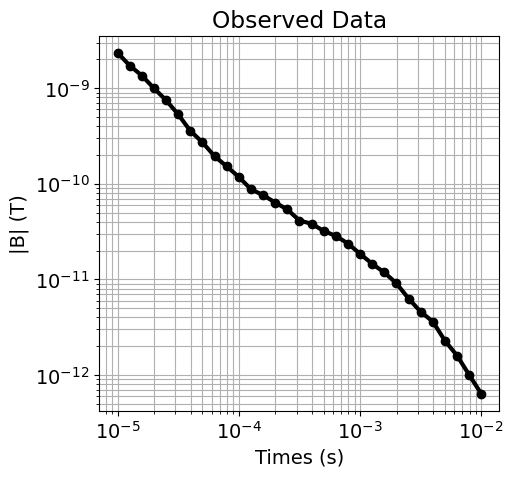

In [5]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax.loglog(times, np.abs(dobs), "k-o", lw=3)
ax.grid(which="both")
ax.set_xlabel("Times (s)")
ax.set_ylabel("|B| (T)")
ax.set_title("Observed Data")
plt.show()

## Defining the Survey

Here, we define the survey geometry. For a comprehensive description of constructing TDEM surveys in SimPEG, see the [1D Forward Simulation of Time-Domain EM Data for a Single Sounding](fwd_tdem_1d.ipynb) tutorial.

Here, the survey consisted of a circular transmitter loop with a radius of 6 m located 20 m above the Earth's surface. The receiver measured the vertical component of the secondary magnetic field at a the loop's centre.

In [6]:
# Source loop geometry
source_location = np.array([0.0, 0.0, 1.0])  # (3, ) numpy.array_like
source_orientation = "z"  # "x", "y" or "z"
source_current = 1.0  # maximum on-time current (A)
source_radius = 10.0  # source loop radius (m)

# Receiver geometry
receiver_location = np.array([0.0, 0.0, 1.0])  # or (N, 3) numpy.ndarray
receiver_orientation = "z"  # "x", "y" or "z"

# Receiver list
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxDensity(
        receiver_location, times, orientation=receiver_orientation
    )
)

# Define the source waveform.
waveform = tdem.sources.StepOffWaveform()

# Sources
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Survey
survey = tdem.Survey(source_list)

## Assign Uncertainties

Inversion with SimPEG requires that we define the uncertainties on our data; that is, an estimate of the standard deviation of the noise on our data assuming it is uncorrelated Gaussian with zero mean. An online resource explaining uncertainties and their role in the inversion can be found [here](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).

For off-time TDEM data, a percent uncertainty plus a small floor value is generally applied to all data. Depending on many factors, we may apply a percent uncertainty between 5\% and 20\%. The floor uncertainty ensure we do not try to overfit late time channels when the signal to noise become sufficiently small. For systems where multiple field directions are measured for the same source, we may not want to apply a uniform percent uncertainty to all data. Doing so may cause the inversion to overfit weaker components. In this case, the uncertainty may be a percent of the amplitude of the secondary field.

In [7]:
# 5% of the absolute value
uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))

## Defining the Data

The SimPEG [Data](myst:simpeg#simpeg.data.Data) class is required for inversion and connects the observed data, uncertainties and survey geometry.

In [8]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

## Weighted Least-Squares Inversion

Here, we use the weighted least-squares inversion approach to recover the log-conductivities on a 1D layered Earth. We impose no a-priori information about the number of layers (geological units) or their thicknesses. Instead, we define a large number of layers with exponentially increasing thicknesses. And the depth, thickness and electrical properties of the Earth are inferred from the recovered model.

### Defining a 1D Layered Earth

Let us assume we have a reasonable estimate of the regional conductivity within our area of interest. For the earliest time channel and the estimated conductivity, we compute the minimum diffusion distance:

$$
d_{min} \approx 1250 \sqrt{\dfrac{t_{min}}{\sigma}}
$$

The minimum layer thickness is some fraction of the minimum diffusion distance. Next, we use the latest time channel and the estimated conductivity to compute the maximum diffusion distance:

$$
d_{max} \approx 1250 \sqrt{\dfrac{t_{max}}{\sigma}}
$$

Starting from our minimum layer thickness, we continue to add layers with exponentially increasing thicknesses. We do so until the layers extend to some multiple of the maximum diffusion distance.

In [9]:
# estimated host conductivity (S/m)
estimated_conductivity = 0.1

# minimum diffusion distance
d_min = 1250 * np.sqrt(times.min() / estimated_conductivity)
print("MINIMUM DIFFUSION DISTANCE: {} m".format(d_min))

# maximum diffusion distance
d_max = 1250 * np.sqrt(times.max() / estimated_conductivity)
print("MAXIMUM DIFFUSION DISTANCE: {} m".format(d_max))

MINIMUM DIFFUSION DISTANCE: 12.5 m
MAXIMUM DIFFUSION DISTANCE: 395.28470752104744 m


In [10]:
depth_min = 1  # top layer thickness
depth_max = 800.0  # depth to lowest layer
geometric_factor = 1.15  # rate of thickness increase

In [11]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses = [depth_min]
while np.sum(layer_thicknesses) < depth_max:
    layer_thicknesses.append(geometric_factor * layer_thicknesses[-1])

n_layers = len(layer_thicknesses) + 1  # Number of layers

### Model and Mapping to Layer Conductivities

Recall from the [1D Forward Simulation of Time-Domain EM Data for a Single Sounding](fwd_tdem_1d.ipynb) tutorial that the 'model' is not necessarily synonymous with physical property values. And that we need to define a mapping from the model to the set of input parameters required by the forward simulation. When inverting to recover electrical conductivities (or resistivities), it is best to use the log-value, as electrical conductivities of rocks span many order of magnitude.

Here, the model defines the log-conductivity values for a defined set of subsurface layers. And we use the [simpeg.maps.ExpMap](myst:simpeg#simpeg.maps.ExpMap) to map from the model parameters to the conductivity values required by the forward simulation.

In [12]:
log_conductivity_map = maps.ExpMap(nP=n_layers)

### Starting/Reference Models

The **starting model** defines a reasonable starting point for the inversion. Because electromagnetic problems are non-linear, your choice in starting model does have an impact on the recovered model. For DC resistivity inversion, we generally choose our starting model based on apparent resistivities. For the tutorial example, the apparent resistivities were near 1000 $\Omega m$. It should be noted that the starting model **cannot be vector of zeros,** otherwise the inversion will be unable to compute a gradient direction at the first iteration.

The **reference model** is used to include a-priori information. The impact of the reference model on the inversion will be discussed in another tutorial. The reference model for basic inversion approaches is either zero or equal to the starting model.

Notice that the length of the starting and reference models is equal to the number of model parameters!!!

In [13]:
# Starting model is log-conductivity values (S/m)
starting_conductivity_model = np.log(1e-1 * np.ones(n_layers))

# Reference model is also log-resistivity values (S/m)
reference_conductivity_model = starting_conductivity_model.copy()

### Define the Forward Simulation

A simulation object defining the forward problem is required in order to predict data and calculate misfits for recovered models. A comprehensive description of the simulation object for 1D DC resistivity was discussed in the [1D Forward Simulation of Time-Domain EM Data for a Single Sounding](fwd_tdem_1d.ipynb) tutorial. Here, we use the [Simulation1DLayers](myst:simpeg#simpeg.electromagnetics.time_domain.Simulation1DLayers) which simulates the data according to a 1D Hankel transform solution.

The layer thicknesses are a static property of the simulation, and we set them using the ``thicknessess`` keyword argument. Since our model consists of log-conductivities, we use ``sigmaMap`` to set the mapping from the model to the layer conductivities.

In [14]:
simulation_L2 = tdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses, sigmaMap=log_conductivity_map
)

### Data Misfit

To understand the role of the data misfit in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).
Here, we use the [L2DataMisfit](myst:simpeg#simpeg.data_misfit.L2DataMisfit) class to define the data misfit. In this case, the data misfit is the L2 norm of the weighted residual between the observed data and the data predicted for a given model. When instantiating the data misfit object within SimPEG, we must assign an appropriate *data object* and *simulation object* as properties.

In [15]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

### Regularization

To understand the role of the regularization in the inversion, please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/ObjectiveFunction.html). 

To define the regularization within SimPEG, we must define a 1D [tensor mesh](myst:discretize#discretize.TensorMesh). Meshes are designed using the [discretize package](https://discretize.simpeg.xyz). Whereas layer *thicknesses* and our *model* are defined from our top-layer down, tensor meshes are defined from the bottom up. So to define a 1D tensor mesh for the regularization, we:

- add an extra layer to the end of our thicknesses so that the number of cells in the 1D mesh equals the number of model parameters
- reverse the order so that the model parameters in the regularization match up with the appropriate cell
- define the tensor mesh from the cell widths

In [16]:
# Define 1D cell widths
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 36 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     36       -996.97         -0.00      1.00    115.80    1.15




By default, the regularization acts on the model parameters. In this case, the model parameters are the log-resistivities, not the electric resistivities!!! Here, we use the [WeightedLeastSquares](myst:simpeg#simpeg.regularization.WeightedLeastSquares) regularization class to constrain the inversion result. Here, length scale along x are used to balance the smallness and smoothness terms; yes, x is smoothness along the vertical direction. And the reference model is only applied to the smallness term. If we wanted to apply the regularization to a function of the model parameters, we would need to set an approprate mapping object using the ``mapping`` keyword argument.

In [17]:
reg_L2 = regularization.WeightedLeastSquares(
    regularization_mesh,
    length_scale_x=10.0,
    reference_model=reference_conductivity_model,
    reference_model_in_smooth=False,
)

### Optimization

Here, we use the [InexactGaussNewton](myst:simpeg#simpeg.optimization.InexactGaussNewton) class to solve the optimization problem using the inexact Gauss Newton with conjugate gradient solver. Reasonable default values have generally been set for the properties of each optimization class. However, the user may choose to set custom values; e.g. the accuracy tolerance for the conjugate gradient solver or the number of line searches.

In [18]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

### Inverse Problem

We use the [BaseInvProblem](myst:simpeg#simpeg.inverse_problem.BaseInvProblem) class to fully define the inverse problem that is solved at each beta (trade-off parameter) iteration. The inverse problem requires appropriate *data misfit*, *regularization* and *optimization* objects.

In [19]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

### Inversion Directives

To understand the role of directives in the inversion, please visit this online resource. Here, we apply common directives for weighted least-squares inversion of gravity data and describe their roles. These are:

- [UpdatePreconditioner](myst:simpeg#simpeg.directives.UpdatePreconditioner): Apply Jacobi preconditioner when solving optimization problem to reduce the number of conjugate gradient iterations. We set `update_every_iteration=True` because the ideal preconditioner is model-dependent.

- [BetaEstimate_ByEig](myst:simpeg#simpeg.directives.BetaEstimate_ByEig): Compute and set starting trade-off parameter (beta) based on largest eigenvalues.

- [BetaSchedule](myst:simpeg#simpeg.directives.BetaSchedule): Size reduction of the trade-off parameter at every beta iteration, and the number of Gauss-Newton iterations for each beta. In general, a `coolingFactor` between 1.5 and 2.5, and `coolingRate` of 3 works well for TDEM inversion. Cooling beta too quickly will result in portions of the model getting trapped in local minima. And we will not be finding the solution that minimizes the optimization problem if the cooling rate is too small.

- [TargetMisfit](myst:simpeg#simpeg.directives.TargetMisfit): Terminates the inversion when the data misfit equals the target misfit. A `chifact=1` terminates the inversion when the data misfit equals the number of data.


The directive objects are organized in a ``list``. Upon starting the inversion or updating the recovered model at each iteration, the inversion will call each directive within the list **in order**. The order of the directives matters, and SimPEG will throw an error if directives are organized into an improper order. Some directives, like the ``BetaEstimate_ByEig`` are only used when starting the inversion. Other directives, like ``UpdatePreconditionner``, are used whenever the model is updated.

In [20]:
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [update_jacobi, starting_beta, beta_schedule, target_misfit]

### Define and Run the Inversion

We define the inversion using the [BaseInversion](myst:simpeg#simpeg.inversion.BaseInversion) class. The inversion class must be instantiated with an appropriate *inverse problem* object and *directives list*. The ``run`` method, along with a starting model, is respondible for running the inversion. The output is a 1D numpy.ndarray containing the recovered model parameters

In [21]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_model_L2 = inv_L2.run(starting_conductivity_model)


Running inversion with SimPEG v0.22.1

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.84e+01  4.53e+03  0.00e+00  4.53e+03    8.55e+02      0              


/home/ssoler/mambaforge/envs/simpeg-user-tutorials/lib/python3.10/site-packages/simpeg/optimization.py:1072: UserWarning: tol is not a valid keyword for cg and will be ignored
  Hinv = SolverICG(


   1  1.84e+01  3.70e+03  1.75e+01  4.03e+03    2.17e+02      0              


   2  1.84e+01  3.44e+03  2.93e+01  3.98e+03    8.46e+01      0   Skip BFGS  


   3  9.20e+00  3.33e+03  3.47e+01  3.65e+03    4.56e+02      0   Skip BFGS  


   4  9.20e+00  2.28e+03  1.03e+02  3.23e+03    2.82e+02      0              


   5  9.20e+00  1.68e+03  1.51e+02  3.07e+03    1.99e+02      0   Skip BFGS  


   6  4.60e+00  1.34e+03  1.80e+02  2.16e+03    5.82e+02      0   Skip BFGS  


   7  4.60e+00  3.79e+02  2.94e+02  1.73e+03    1.36e+02      0              


   8  4.60e+00  2.49e+02  3.04e+02  1.65e+03    9.80e+01      0              


   9  2.30e+00  1.98e+02  3.05e+02  9.01e+02    3.14e+02      0   Skip BFGS  


  10  2.30e+00  6.77e+01  3.35e+02  8.38e+02    1.45e+02      0              


  11  2.30e+00  5.39e+01  3.29e+02  8.11e+02    1.07e+02      0              


  12  1.15e+00  5.19e+01  3.23e+02  4.23e+02    1.17e+02      0   Skip BFGS  


  13  1.15e+00  3.27e+01  3.32e+02  4.15e+02    5.23e+01      0   Skip BFGS  


  14  1.15e+00  3.14e+01  3.32e+02  4.14e+02    1.01e+01      0              


------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 4.5289e+02
1 : |xc-x_last| = 6.6781e-02 <= tolX*(1+|x0|) = 1.4816e+00
0 : |proj(x-g)-x|    = 1.0134e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 1.0134e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =     100    <= iter          =     15
------------------------- DONE! -------------------------


## Inversion Outputs

### Data Misfit

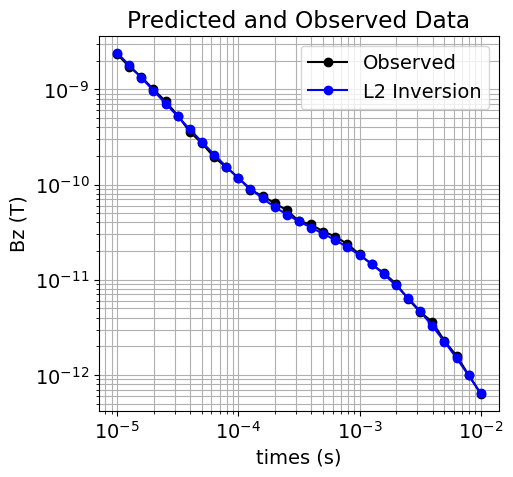

In [22]:
dpred_L2 = simulation_L2.dpred(recovered_model_L2)

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax1.loglog(times, np.abs(dobs), "k-o")
ax1.loglog(times, np.abs(dpred_L2), "b-o")
ax1.grid(which="both")
ax1.set_xlabel("times (s)")
ax1.set_ylabel("Bz (T)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(["Observed", "L2 Inversion"], loc="upper right")
plt.show()

### Recovered Model

In [23]:
# Load the true model and layer thicknesses
true_conductivities = np.array([0.1, 1.0, 0.1])
true_layers = np.r_[40.0, 40.0, 160.0]

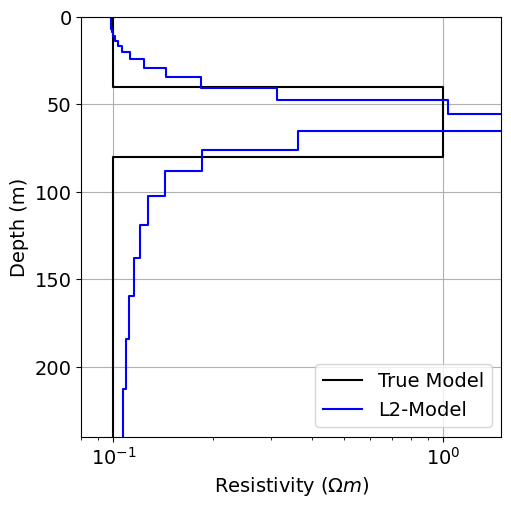

In [24]:
# Plot true model and recovered model
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_layers, true_conductivities, ax=ax1, color="k")
plot_1d_layer_model(
    layer_thicknesses, log_conductivity_map * recovered_model_L2, ax=ax1, color="b"
)
ax1.grid()
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
x_min, x_max = true_conductivities.min(), true_conductivities.max()
ax1.set_xlim(0.8 * x_min, 1.5 * x_max)
ax1.set_ylim([np.sum(true_layers), 0])
ax1.legend(["True Model", "L2-Model"])
plt.show()

## Iteratively Re-weighted Least-Squares Inversion

Here, we use the iteratively reweighted least-squares (IRLS) inversion approach to recover sparse and/or blocky models on the set layers.

### Define the Forward Simulation

In [25]:
simulation_irls = tdem.simulation_1d.Simulation1DLayered(
    survey=survey,
    sigmaMap=log_conductivity_map,
    thicknesses=layer_thicknesses,
)

### Define the Data Misfit

In [26]:
dmis_irls = data_misfit.L2DataMisfit(simulation=simulation_irls, data=data_object)

### Regularization

Here, we use the [Sparse](myst:simpeg#simpeg.regularization.Sparse) regularization class to constrain the inversion result using an IRLS approach. Here, the scaling constants that balance the smallness and smoothness terms are set directly. Equal emphasis on smallness and smoothness is generally applied by using the inverse square of the smallest cell dimension. The reference model is only applied to the smallness term; which is redundant for the tutorial example since we have set the reference model to an array of zeros. Here, we apply a 1-norm to the smallness term and a 1-norm to first-order smoothness along the x (vertical direction).

In [27]:
reg_irls = regularization.Sparse(
    regularization_mesh,
    alpha_s=0.01,
    alpha_x=1,
    reference_model_in_smooth=False,
    norms=[1.0, 1.0],
)

### Optimization

In [28]:
opt_irls = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=30, tolCG=1e-3
)

### Inverse Problem

In [29]:
inv_prob_irls = inverse_problem.BaseInvProblem(dmis_irls, reg_irls, opt_irls)

### Directives

Here, we create common directives for IRLS inversion of total magnetic intensity data and describe their roles. In additon to the [UpdateSensitivityWeights](myst:simpeg#simpeg.directives.UpdateSensitivityWeights), [UpdatePreconditioner](myst:simpeg#simpeg.directives.UpdatePreconditioner) and [BetaEstimate_ByEig](myst:simpeg#simpeg.directives.BetaEstimate_ByEig)  (described before), inversion with sparse-norms requires the [`UpdateIRLS`](myst:simpeg#simpeg.directives.UpdateIRLS) directive.

You will notice that we don't use the [BetaSchedule](myst:simpeg#simpeg.directives.BetaSchedule) and [TargetMisfit](myst:simpeg#simpeg.directives.TargetMisfit) directives. Here, the beta cooling schedule is set in the [`UpdateIRLS`](myst:simpeg#simpeg.directives.UpdateIRLS) directive using the `coolingFactor` and `coolingRate` properties. The target misfit for the L2 portion of the IRLS approach is set with the `chifact_start` property.

In [30]:
sensitivity_weights_irls = directives.UpdateSensitivityWeights(every_iteration=True)
starting_beta_irls = directives.BetaEstimate_ByEig(beta0_ratio=1)
update_jacobi_irls = directives.UpdatePreconditioner(update_every_iteration=True)
update_irls = directives.UpdateIRLS(
    cooling_factor=2,
    cooling_rate=2,
    f_min_change=1e-4,
    max_irls_iterations=40,
    chifact_start=1.0,
)

directives_list_irls = [
    update_irls,
    sensitivity_weights_irls,
    starting_beta_irls,
    update_jacobi_irls,
]

### Define and Run the Inversion

In [31]:
# Here we combine the inverse problem and the set of directives
inv_irls = inversion.BaseInversion(inv_prob_irls, directives_list_irls)

# Run the inversion
recovered_model_irls = inv_irls.run(starting_conductivity_model)


Running inversion with SimPEG v0.22.1
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.06e+03  4.53e+03  0.00e+00  4.53e+03    8.55e+02      0              


   1  1.06e+03  2.60e+03  6.41e-01  3.29e+03    4.16e+02      0              


   2  5.32e+02  1.73e+03  1.23e+00  2.39e+03    6.07e+02      0   Skip BFGS  


   3  5.32e+02  4.70e+02  2.21e+00  1.65e+03    2.36e+02      0              


   4  2.66e+02  2.59e+02  2.47e+00  9.17e+02    3.34e+02      0   Skip BFGS  


   5  2.66e+02  8.73e+01  2.70e+00  8.06e+02    2.29e+01      0              


   6  1.33e+02  7.66e+01  2.75e+00  4.43e+02    1.61e+02      0   Skip BFGS  


   7  1.33e+02  3.54e+01  2.81e+00  4.10e+02    1.80e+01      0              


   8  6.66e+01  3.34e+01  2.84e+00  2.22e+02    8.22e+01      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
irls_threshold 2.3901213326453723


   9  6.66e+01  2.01e+01  3.06e+00  2.24e+02    2.37e+01      0              


  10  1.20e+02  1.92e+01  2.98e+00  3.78e+02    8.13e+01      0              


  11  1.93e+02  2.56e+01  2.94e+00  5.94e+02    1.06e+02      0              


  12  1.53e+02  3.70e+01  2.93e+00  4.87e+02    3.26e+01      0              


  13  1.53e+02  3.12e+01  2.97e+00  4.86e+02    4.73e+00      0              


  14  1.53e+02  2.98e+01  2.98e+00  4.87e+02    4.13e+00      0   Skip BFGS  


  15  1.53e+02  2.87e+01  2.99e+00  4.87e+02    3.83e+00      0   Skip BFGS  


  16  2.39e+02  2.77e+01  3.00e+00  7.45e+02    1.11e+02      0   Skip BFGS  


  17  1.85e+02  3.90e+01  2.98e+00  5.89e+02    5.79e+01      0              


  18  1.85e+02  3.14e+01  3.01e+00  5.88e+02    5.61e+00      0              


  19  1.85e+02  3.02e+01  3.02e+00  5.88e+02    3.94e+00      0   Skip BFGS  


  20  1.85e+02  2.96e+01  3.03e+00  5.90e+02    3.67e+00      0   Skip BFGS  


  21  1.85e+02  2.91e+01  3.04e+00  5.91e+02    3.61e+00      0   Skip BFGS  


  22  1.85e+02  2.87e+01  3.05e+00  5.93e+02    3.66e+00      0   Skip BFGS  


  23  1.85e+02  2.84e+01  3.06e+00  5.94e+02    3.77e+00      0   Skip BFGS  


  24  1.85e+02  2.83e+01  3.07e+00  5.96e+02    3.92e+00      0   Skip BFGS  


  25  1.85e+02  2.81e+01  3.08e+00  5.98e+02    4.10e+00      0              


  26  1.85e+02  2.81e+01  3.09e+00  6.00e+02    4.29e+00      0              


  27  1.85e+02  2.80e+01  3.10e+00  6.02e+02    4.50e+00      0              


  28  1.85e+02  2.81e+01  3.12e+00  6.04e+02    4.73e+00      0              


  29  1.85e+02  2.81e+01  3.13e+00  6.06e+02    5.01e+00      0              


  30  1.85e+02  2.82e+01  3.15e+00  6.09e+02    5.33e+00      0              


  31  1.85e+02  2.84e+01  3.16e+00  6.13e+02    5.72e+00      0              


  32  1.85e+02  2.86e+01  3.18e+00  6.17e+02    6.16e+00      0              


  33  1.85e+02  2.89e+01  3.20e+00  6.20e+02    6.17e+00      0              


  34  1.85e+02  2.92e+01  3.20e+00  6.21e+02    6.02e+00      0              


  35  1.85e+02  2.94e+01  3.21e+00  6.22e+02    6.15e+00      0              


  36  1.85e+02  2.97e+01  3.21e+00  6.23e+02    6.22e+00      0              


  37  1.85e+02  3.00e+01  3.22e+00  6.25e+02    6.18e+00      0              


  38  1.85e+02  3.03e+01  3.22e+00  6.26e+02    6.06e+00      0   Skip BFGS  


  39  1.85e+02  3.06e+01  3.23e+00  6.27e+02    5.87e+00      0   Skip BFGS  


  40  1.85e+02  3.09e+01  3.23e+00  6.29e+02    5.66e+00      0   Skip BFGS  


  41  1.85e+02  3.12e+01  3.24e+00  6.30e+02    5.44e+00      0   Skip BFGS  


  42  1.85e+02  3.15e+01  3.24e+00  6.30e+02    5.25e+00      0   Skip BFGS  


  43  1.85e+02  3.17e+01  3.24e+00  6.31e+02    5.10e+00      0   Skip BFGS  


  44  1.85e+02  3.19e+01  3.25e+00  6.32e+02    4.99e+00      0   Skip BFGS  


  45  1.85e+02  3.20e+01  3.25e+00  6.32e+02    4.91e+00      0   Skip BFGS  


  46  1.85e+02  3.22e+01  3.25e+00  6.32e+02    4.86e+00      0   Skip BFGS  


  47  1.85e+02  3.23e+01  3.25e+00  6.33e+02    4.83e+00      0   Skip BFGS  


  48  1.85e+02  3.24e+01  3.25e+00  6.33e+02    4.81e+00      0   Skip BFGS  
Reach maximum number of IRLS cycles: 40
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 4.5289e+02
1 : |xc-x_last| = 5.7697e-03 <= tolX*(1+|x0|) = 1.4816e+00
0 : |proj(x-g)-x|    = 4.8122e+00 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 4.8122e+00 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =     100    <= iter          =     49
------------------------- DONE! -------------------------


### Data Misfit and Recovered Model

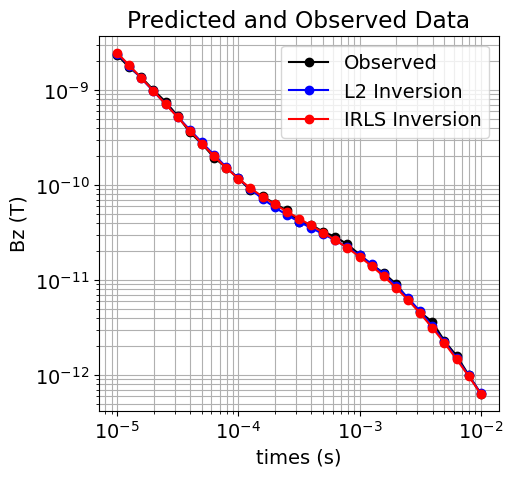

In [32]:
dpred_irls = simulation_irls.dpred(recovered_model_irls)

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax1.loglog(times, np.abs(dobs), "k-o")
ax1.loglog(times, np.abs(dpred_L2), "b-o")
ax1.loglog(times, np.abs(dpred_irls), "r-o")
ax1.grid(which="both")
ax1.set_xlabel("times (s)")
ax1.set_ylabel("Bz (T)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(["Observed", "L2 Inversion", "IRLS Inversion"], loc="upper right")
plt.show()

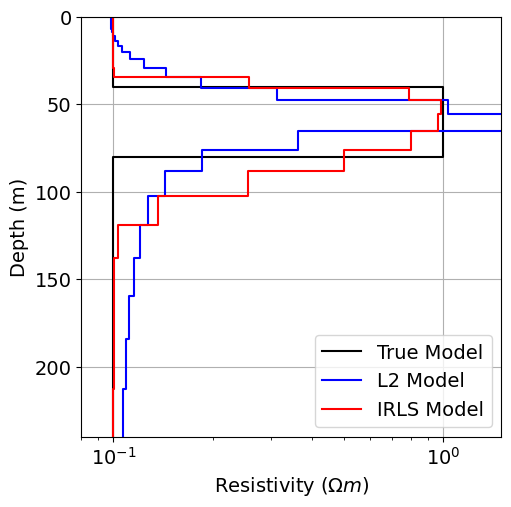

In [33]:
# Plot true model and recovered model
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_layers, true_conductivities, ax=ax1, color="k")
plot_1d_layer_model(
    layer_thicknesses, log_conductivity_map * recovered_model_L2, ax=ax1, color="b"
)
plot_1d_layer_model(
    layer_thicknesses, log_conductivity_map * recovered_model_irls, ax=ax1, color="r"
)
ax1.grid()
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
ax1.set_xlim(0.8 * x_min, 1.5 * x_max)
ax1.set_ylim([np.sum(true_layers), 0])
ax1.legend(["True Model", "L2 Model", "IRLS Model"])
plt.show()

## Parametric Inversion

Here, we assume the subsurface is defined by a 3-layered Earth. However, the electrical properties and thicknesses of the layers are unknown. Here, we define our model to include log-conductivities and log-thicknesses. When including quantities that span different scales, it is frequently best to define the model in terms of log values so that each quantity influences the predicted data evenly.

### Model and Mapping

For a 3-layered Earth model, the model consists of 2 log-thicknesses and 3 log-conductivities. Similar to the [1D Forward Simulation of Time Domain EM Data for a Single Sounding](fwd_tdem_1d.ipynb) tutorial, need a mapping that extract log-thicknesses and log-resistivities from the model, and mappings that convert log-values to property values. For this, we require the [simpeg.maps.Wires](myst:simpeg#simpeg.maps.Wires) mapping and [simpeg.maps.ExpMap](myst:simpeg#simpeg.maps.ExpMap) mapping classes. Note that successive mappings can be chained together using the $*$ operator.

In [34]:
# Wire maps to extract log-thicknesses and log-conductivities
wire_map = maps.Wires(("log_thicknesses", 2), ("log_resistivity", 3))

# Maping for layer thicknesses
log_thicknesses_map = maps.ExpMap() * wire_map.log_thicknesses

# Mapping for conductivities
log_resistivity_map = maps.ExpMap() * wire_map.log_resistivity

### Starting and Reference Model

This problem is highly non-linear so it is important to have a reasonable estimate of the true model. 

In [35]:
starting_parametric_model = np.log(np.r_[30.0, 20.0, 20, 0.5, 5])

reference_parametric_model = starting_parametric_model.copy()

### Forward Simulation

Because the layer thicknesses are part of the model, we define the ``thicknessesMap``. Because we are working in terms of electrical resistivity, we must define the ``rhoMap``.

In [36]:
simulation_parametric = tdem.simulation_1d.Simulation1DLayered(
    survey=survey,
    rhoMap=log_resistivity_map,
    thicknessesMap=log_thicknesses_map,
)

### Data Misfit

In [37]:
dmis_parametric = data_misfit.L2DataMisfit(
    simulation=simulation_parametric, data=data_object
)

### (Combo) Regularization

We need to define a regularization for each model parameter type. In this case, we have log-thicknesses and log-conductivities. For each model parameter type, we create a 1D [tensor mesh](myst:discretize#discretize.TensorMesh) with length equal to the number of parameters. In the ``mapping`` keyword argument, we used the wire map that extracts the specific model parameters from the model.

Using the $*$ operator, separate regularizations can be summed to form a regularization that is also a [ComboObjectiveFunction](myst:simpeg#simpeg.objective_function.ComboObjectiveFunction). By setting the ``multipliers`` property, we can emphasize the relative contributions of the log-thicknesses and log-conductivities regularizations.

In [38]:
reg_1 = regularization.Smallness(
    TensorMesh([(np.ones(2))], "0"),
    mapping=wire_map.log_thicknesses,
    reference_model=reference_parametric_model,
)

reg_2 = regularization.Smallness(
    TensorMesh([(np.ones(3))], "0"),
    mapping=wire_map.log_resistivity,
    reference_model=reference_parametric_model,
)

reg_parametric = reg_1 + reg_2
reg_parametric.multipliers = [1.0, 0.1]

### Optimization

In [39]:
opt_parametric = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

### Inverse Problem

In [40]:
inv_prob_parametric = inverse_problem.BaseInvProblem(
    dmis_parametric, reg_parametric, opt_parametric
)

### Directives

In [41]:
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_parametric = [
    update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

### Define and Run Inversion

In [42]:
inv_parametric = inversion.BaseInversion(
    inv_prob_parametric, directives_list_parametric
)
recovered_model_parametric = inv_parametric.run(starting_parametric_model)


Running inversion with SimPEG v0.22.1

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.97e+05  6.56e+03  0.00e+00  6.56e+03    3.99e+04      0              


   1  7.97e+05  4.38e+03  1.20e-03  5.34e+03    2.84e+03      0              
   2  7.97e+05  4.50e+03  1.05e-03  5.34e+03    2.16e+02      0              


   3  3.99e+05  4.49e+03  1.06e-03  4.92e+03    1.39e+04      0              
   4  3.99e+05  3.55e+03  2.83e-03  4.68e+03    1.38e+03      0              


   5  3.99e+05  3.63e+03  2.62e-03  4.67e+03    1.45e+02      0              
   6  1.99e+05  3.62e+03  2.65e-03  4.15e+03    1.11e+04      0              


   7  1.99e+05  2.72e+03  5.98e-03  3.91e+03    1.18e+03      0              
   8  1.99e+05  2.80e+03  5.59e-03  3.91e+03    1.39e+02      0              


   9  9.96e+04  2.79e+03  5.64e-03  3.35e+03    8.31e+03      0              
  10  9.96e+04  2.07e+03  1.09e-02  3.16e+03    7.94e+02      0              


  11  9.96e+04  2.12e+03  1.04e-02  3.15e+03    9.31e+01      0              
  12  4.98e+04  2.11e+03  1.05e-02  2.63e+03    5.83e+03      0              


  13  4.98e+04  1.57e+03  1.83e-02  2.48e+03    4.25e+02      0              
  14  4.98e+04  1.57e+03  1.81e-02  2.48e+03    5.65e+01      0              


  15  2.49e+04  1.57e+03  1.83e-02  2.02e+03    3.98e+03      0   Skip BFGS  
  16  2.49e+04  1.09e+03  3.16e-02  1.88e+03    2.79e+02      0              


  17  2.49e+04  1.04e+03  3.34e-02  1.87e+03    8.69e+01      0   Skip BFGS  
  18  1.25e+04  1.02e+03  3.41e-02  1.45e+03    2.81e+03      0   Skip BFGS  


  19  1.25e+04  5.68e+02  5.87e-02  1.30e+03    2.41e+02      0              
  20  1.25e+04  5.24e+02  6.19e-02  1.30e+03    5.30e+01      0   Skip BFGS  


  21  6.23e+03  5.16e+02  6.26e-02  9.06e+02    2.01e+03      0   Skip BFGS  
  22  6.23e+03  2.45e+02  9.25e-02  8.21e+02    7.39e+01      0              


  23  6.23e+03  2.42e+02  9.29e-02  8.20e+02    1.68e+01      0   Skip BFGS  
  24  3.11e+03  2.40e+02  9.31e-02  5.30e+02    1.33e+03      0   Skip BFGS  


  25  3.11e+03  1.12e+02  1.22e-01  4.91e+02    6.21e+01      0              
  26  3.11e+03  1.13e+02  1.21e-01  4.90e+02    1.05e+01      0              


  27  1.56e+03  1.12e+02  1.21e-01  3.01e+02    8.14e+02      0   Skip BFGS  
  28  1.56e+03  5.68e+01  1.46e-01  2.84e+02    3.85e+01      0              


  29  1.56e+03  5.68e+01  1.46e-01  2.84e+02    5.11e+00      0              
  30  7.78e+02  5.65e+01  1.46e-01  1.70e+02    4.70e+02      0   Skip BFGS  


  31  7.78e+02  3.54e+01  1.64e-01  1.63e+02    1.65e+01      0              
  32  7.78e+02  3.51e+01  1.65e-01  1.63e+02    2.21e+00      0   Skip BFGS  


  33  3.89e+02  3.50e+01  1.65e-01  9.91e+01    2.58e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 6.5612e+02
1 : |xc-x_last| = 4.2279e-02 <= tolX*(1+|x0|) = 6.7086e-01
0 : |proj(x-g)-x|    = 2.5833e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 2.5833e+02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =     100    <= iter          =     34
------------------------- DONE! -------------------------


### Data Misfit and Recovered Model

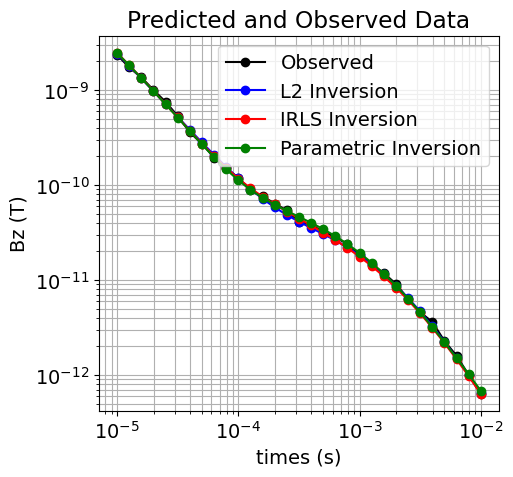

In [43]:
dpred_parametric = simulation_parametric.dpred(recovered_model_parametric)

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax1.loglog(times, np.abs(dobs), "k-o")
ax1.loglog(times, np.abs(dpred_L2), "b-o")
ax1.loglog(times, np.abs(dpred_irls), "r-o")
ax1.loglog(times, np.abs(dpred_parametric), "g-o")
ax1.grid(which="both")
ax1.set_xlabel("times (s)")
ax1.set_ylabel("Bz (T)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(
    ["Observed", "L2 Inversion", "IRLS Inversion", "Parametric Inversion"],
    loc="upper right",
)
plt.show()

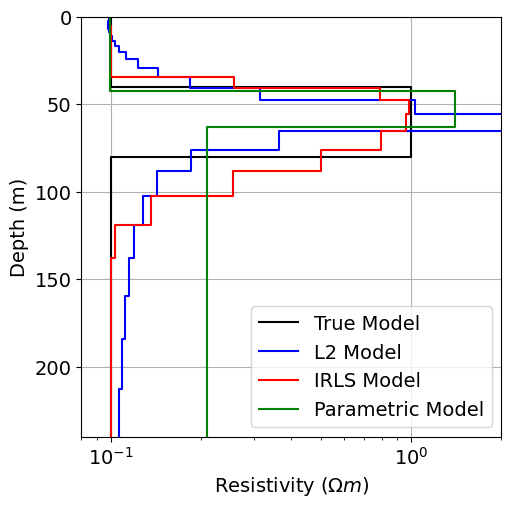

In [44]:
fig = plt.figure(figsize=(6, 6))

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_layers, true_conductivities, ax=ax1, color="k")
plot_1d_layer_model(
    layer_thicknesses, log_conductivity_map * recovered_model_L2, ax=ax1, color="b"
)
plot_1d_layer_model(
    layer_thicknesses, log_conductivity_map * recovered_model_irls, ax=ax1, color="r"
)
plot_1d_layer_model(
    log_thicknesses_map * recovered_model_parametric,
    1 / (log_resistivity_map * recovered_model_parametric),
    ax=ax1,
    color="g",
)
ax1.grid()
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
ax1.set_xlim(0.8 * x_min, 2 * x_max)
ax1.set_ylim([np.sum(true_layers), 0])
ax1.legend(["True Model", "L2 Model", "IRLS Model", "Parametric Model"])
plt.show()